## Scrape reviews from Skytrax (Beautiful Soup)

In [298]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import datetime
from collections import defaultdict

In [209]:
def get_reviews(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    review_raw = soup.find_all('div', class_ = 'text_content')
    reviews = [r.text.strip()[18:].strip() if re.findall('Verified',r.text.strip()) != [] else r.text.strip() for r in review_raw]
    return reviews


In [295]:
def get_times(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    time_raw = soup.find_all('time')
    times = [t.text for t in time_raw]
    return times

In [296]:
airlines = ['alaska-airlines','american-airlines','jetblue-airways','delta-air-lines','united-airlines',
            'frontier-airlines','spirit-airlines','southwest-airlines','hawaiian-airlines','virgin-america']
air_reviews = {}
air_times = {}
for a in airlines:
    reviews = []
    dates = []
    for i in range(1, 31):
        url = 'http://www.airlinequality.com/airline-reviews/{}/page/{}/'.format(a,i)
        r = get_reviews(url)
        t = get_times(url)
        reviews += r 
        dates += t
    air_reviews[a] = reviews
    air_times[a] = dates

## Preprocessing

In [211]:
import os
import json
import pandas as pd
import numpy as np
from gensim import corpora, models
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


### Airlines and Times

In [213]:
n = len(air_reviews_words)
airlines_short_complete = [name for aa in [[a]*300 for a in airlines_short] for name in aa]

In [308]:
time_complete = []
for t in air_times:
    time_complete.extend(air_times[t])

In [309]:
time_complete = [datetime.strptime(' '.join(t.split(' ')[1:]),'%B %Y') for t in time_complete]
time_complete_converted = [str(t.year) + '-' + str(t.month) for t in time_complete]

### Tokenization and Lemmatization

In [212]:
air_reviews_words = []
tokenizer = RegexpTokenizer(r'\w+')
stopword = stopwords.words('english')
extraword = ['u','would','get','got','could','even','fly','flight','airline','plane']
airlines_short = ['alaska','american','jetblue','delta','united','frontier','spirit','southwest','hawaiian','virgin']
p_stem = PorterStemmer()
wn_lemma = WordNetLemmatizer()
for a in air_reviews:
    for r in air_reviews[a]:
        tokens = tokenizer.tokenize(r)  
        tokens_stop = [t.lower() for t in tokens if t.lower() not in stopword]   
        tokens_lemma = [wn_lemma.lemmatize(t) for t in tokens_stop]
        tokens_air = [t for t in tokens_lemma if t not in extraword]
        tokens_air = [t for t in tokens_air if t not in airlines_short] 
        air_reviews_words.append(tokens_air)

#### This part is used to check high-frequency but useless words

In [214]:
all_review = [r for x in air_reviews_words for r in x]
c = Counter(all_review)

In [216]:
c_sort = sorted(c.items(), key = lambda x: x[1], reverse = True)

In [217]:
c_sort[:40]

[('seat', 2392),
 ('time', 2368),
 ('hour', 1896),
 ('service', 1753),
 ('one', 1194),
 ('first', 1190),
 ('customer', 1169),
 ('bag', 1104),
 ('back', 990),
 ('check', 934),
 ('gate', 930),
 ('airport', 927),
 ('told', 918),
 ('never', 876),
 ('day', 872),
 ('ticket', 855),
 ('delayed', 838),
 ('staff', 830),
 ('minute', 795),
 ('attendant', 788),
 ('experience', 778),
 ('good', 752),
 ('flying', 740),
 ('new', 736),
 ('2', 735),
 ('boarding', 731),
 ('crew', 730),
 ('another', 684),
 ('trip', 684),
 ('flew', 680),
 ('way', 679),
 ('next', 652),
 ('passenger', 643),
 ('food', 640),
 ('said', 638),
 ('class', 592),
 ('pay', 590),
 ('great', 584),
 ('3', 584),
 ('delay', 580)]

## Get top 5 topics

In [218]:
dictionary = corpora.Dictionary(air_reviews_words)
#convert speeches to word vectors
corpus = [dictionary.doc2bow(r) for r in air_reviews_words]

In [219]:
lda = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=10, random_state = 3)

In [220]:
top_words = []
for i in range(5):
    top_words.append(tuple([w for (w,prob) in lda.show_topic(i)]))
topics = pd.DataFrame(top_words)

In [221]:
topics

,0,1,2,3,4,5,6,7,8,9
0,seat,service,good,first,food,time,class,cabin,crew,staff
1,hour,customer,told,time,said,service,airport,never,delayed,back
2,time,hour,day,seat,delay,ticket,delayed,one,trip,customer
3,bag,check,service,hour,carry,honolulu,first,one,passenger,checked
4,gate,time,minute,agent,service,boarding,one,check,back,bag


## Trend in topics

In [222]:
#convert speeches to topic vectors
reviews_lda = [lda[c] for c in corpus]
#get topic distribution
topics_dist = {}
for i in range(5):
    topics_dist[i] = [0]*n
for i,s in enumerate(reviews_lda):
    for t in s:
        topics_dist[t[0]][i] = t[1]
#convert to df
topics_dist_df = pd.DataFrame(topics_dist)

In [317]:
topics_dist_df.head()

,0,1,2,3,4,airlines,time
0,0.000000,0.412610,0.577651,0.0,0.000000,alaska,February 2018
1,0.558890,0.435397,0.000000,0.0,0.000000,alaska,February 2018
2,0.741424,0.000000,0.000000,0.0,0.245737,alaska,February 2018
3,0.891313,0.000000,0.081065,0.0,0.000000,alaska,February 2018
4,0.000000,0.000000,0.964594,0.0,0.000000,alaska,February 2018


In [341]:
#topics_dist_df['airlines'] = airlines_short_complete
topics_dist_df['time'] = time_complete_converted

In [343]:
topics_airlines_time_df = topics_dist_df.groupby(['airlines','time'])[list(range(5))].mean()

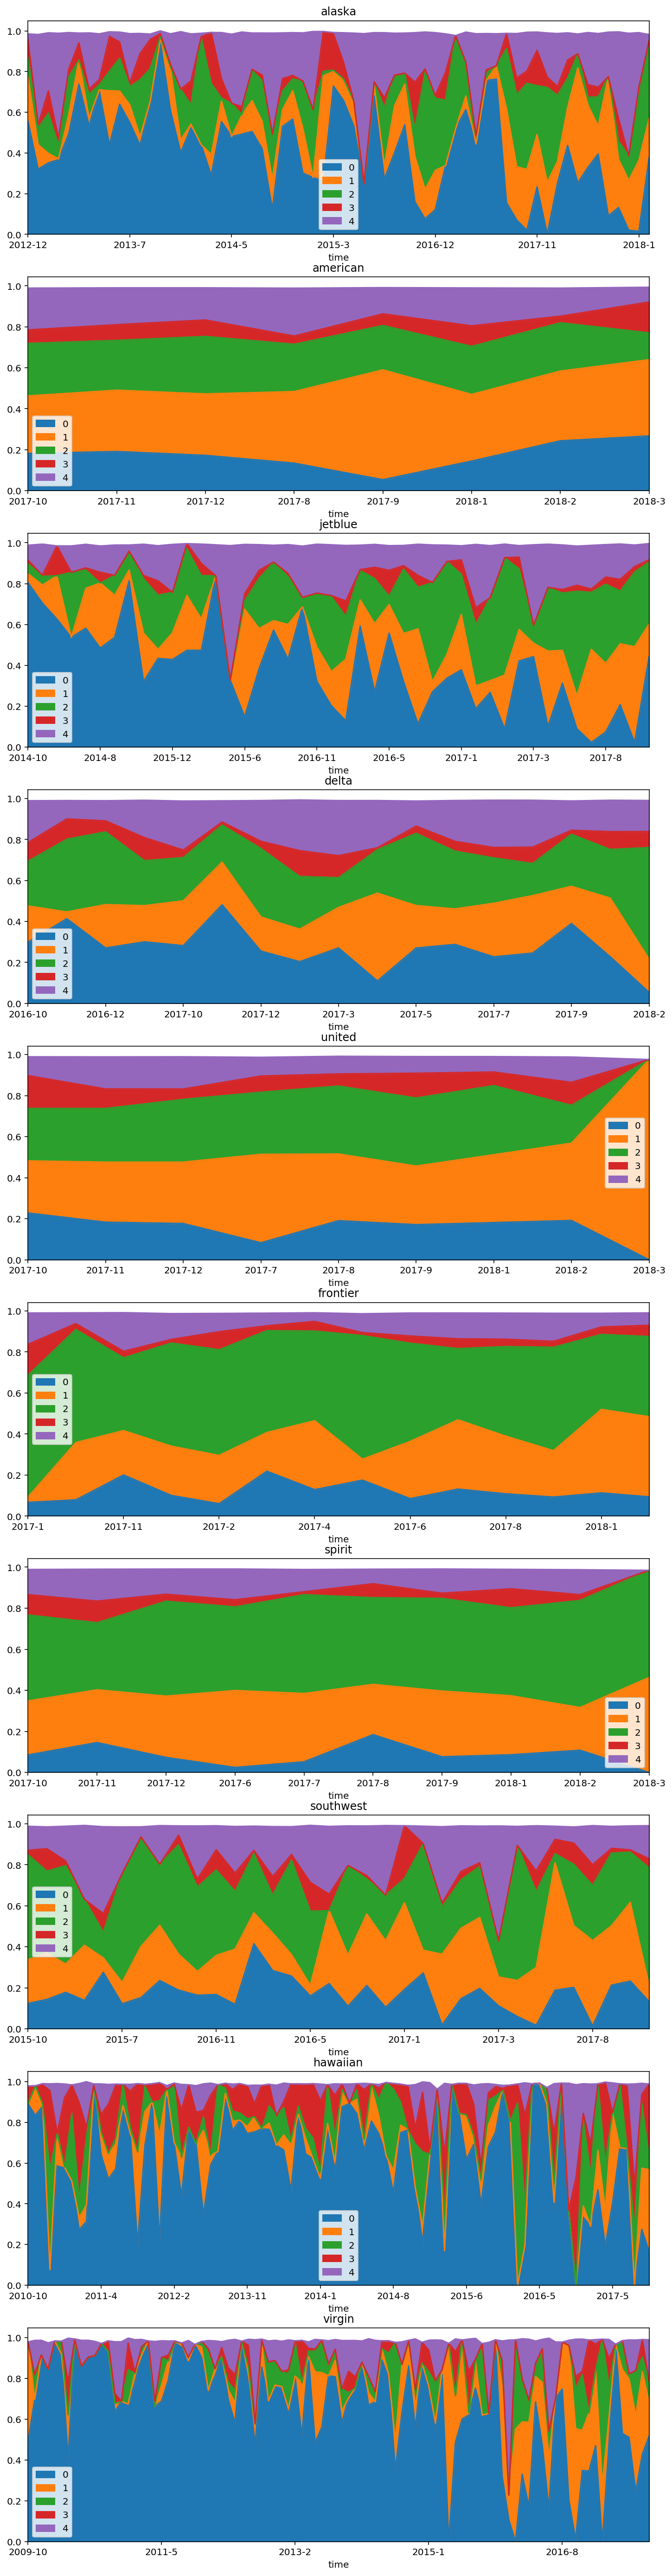

In [345]:
fig, ax_arr = plt.subplots(nrows= 10, ncols=1, figsize = (12,50))
for i,air in enumerate(airlines_short):
    topics_airlines_time_df.loc[air].plot(kind = 'area', ax = ax_arr[i], title = air)    

## Correlation Matrix (based on topic mentioning)

In [225]:
airlines_corr = topics_airlines_df.T.corr()
airlines_corr

airlines,alaska,american,delta,frontier,hawaiian,jetblue,southwest,spirit,united,virgin
airlines,,,,,,,,,,
alaska,1.000000,0.112439,0.757719,-0.039548,0.816450,0.846457,0.208197,-0.132447,0.040033,0.908041
american,0.112439,1.000000,0.654783,0.736238,-0.232600,0.522103,0.721309,0.738367,0.919371,-0.045144
delta,0.757719,0.654783,1.000000,0.603332,0.404136,0.974733,0.765416,0.533104,0.636691,0.554723
frontier,-0.039548,0.736238,0.603332,1.000000,-0.295819,0.482873,0.935339,0.994163,0.874986,-0.219782
hawaiian,0.816450,-0.232600,0.404136,-0.295819,1.000000,0.594127,-0.199556,-0.396580,-0.151771,0.971776
jetblue,0.846457,0.522103,0.974733,0.482873,0.594127,1.000000,0.635992,0.396281,0.542582,0.713761
southwest,0.208197,0.721309,0.765416,0.935339,-0.199556,0.635992,1.000000,0.918519,0.768576,-0.080452
spirit,-0.132447,0.738367,0.533104,0.994163,-0.396580,0.396281,0.918519,1.000000,0.862820,-0.319993
united,0.040033,0.919371,0.636691,0.874986,-0.151771,0.542582,0.768576,0.862820,1.000000,-0.032917


## Clustering

In [352]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import manifold

In [347]:
reviews_sent = []
for a in air_reviews:
    reviews_sent.append(' '.join(air_reviews[a]))

In [349]:
reviews_sent_df = pd.DataFrame({'airline': airlines_short, 'review': reviews_sent})

In [350]:
reviews_sent_df.head()

,airline,review
0,alaska,"This flight was completely canceled due to ""hi..."
1,american,Boston to Phoenix. Let me start by saying we t...
2,jetblue,First time ever flying JetBlue. I wasn’t disap...
3,delta,vFt Lauderdale to Oklahoma City via Atlanta. I...
4,united,San Francisco to Miami. Pretty unimpressed. Th...


In [369]:
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(reviews_sent_df.review).toarray()
kmeans = KMeansClusterer(2, distance=cosine_distance, repeats=50)
clusters = kmeans.cluster(X, assign_clusters=True)

### Visualization

In [370]:
cosine_matrix = cosine_similarity(X)
for i in range(len(airlines_short)):
    for j in range(len(airlines_short)):
        cosine_matrix[i][j] = 1/(cosine_matrix[i][j] + 0.001)

In [371]:
cosine_matrix

array([[ 0.999001  ,  1.29451528,  1.39632685,  1.38795836,  1.36313211,
         1.48916271,  1.44566228,  1.3978921 ,  1.55295359,  1.36610255],
       [ 1.29451528,  0.999001  ,  1.27074043,  1.27601315,  1.21023752,
         1.30197955,  1.24835435,  1.25286118,  1.57173257,  1.38589619],
       [ 1.39632685,  1.27074043,  0.999001  ,  1.31735912,  1.32481653,
         1.40005776,  1.35671665,  1.36847832,  1.66251415,  1.38068936],
       [ 1.38795836,  1.27601315,  1.31735912,  0.999001  ,  1.32812767,
         1.42076083,  1.39882683,  1.3787954 ,  1.64138702,  1.43014585],
       [ 1.36313211,  1.21023752,  1.32481653,  1.32812767,  0.999001  ,
         1.32000067,  1.3033319 ,  1.31952845,  1.62924412,  1.42523122],
       [ 1.48916271,  1.30197955,  1.40005776,  1.42076083,  1.32000067,
         0.999001  ,  1.33722568,  1.37511884,  1.80292426,  1.56136342],
       [ 1.44566228,  1.24835435,  1.35671665,  1.39882683,  1.3033319 ,
         1.33722568,  0.999001  ,  1.3386499 

In [372]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(cosine_matrix).embedding_

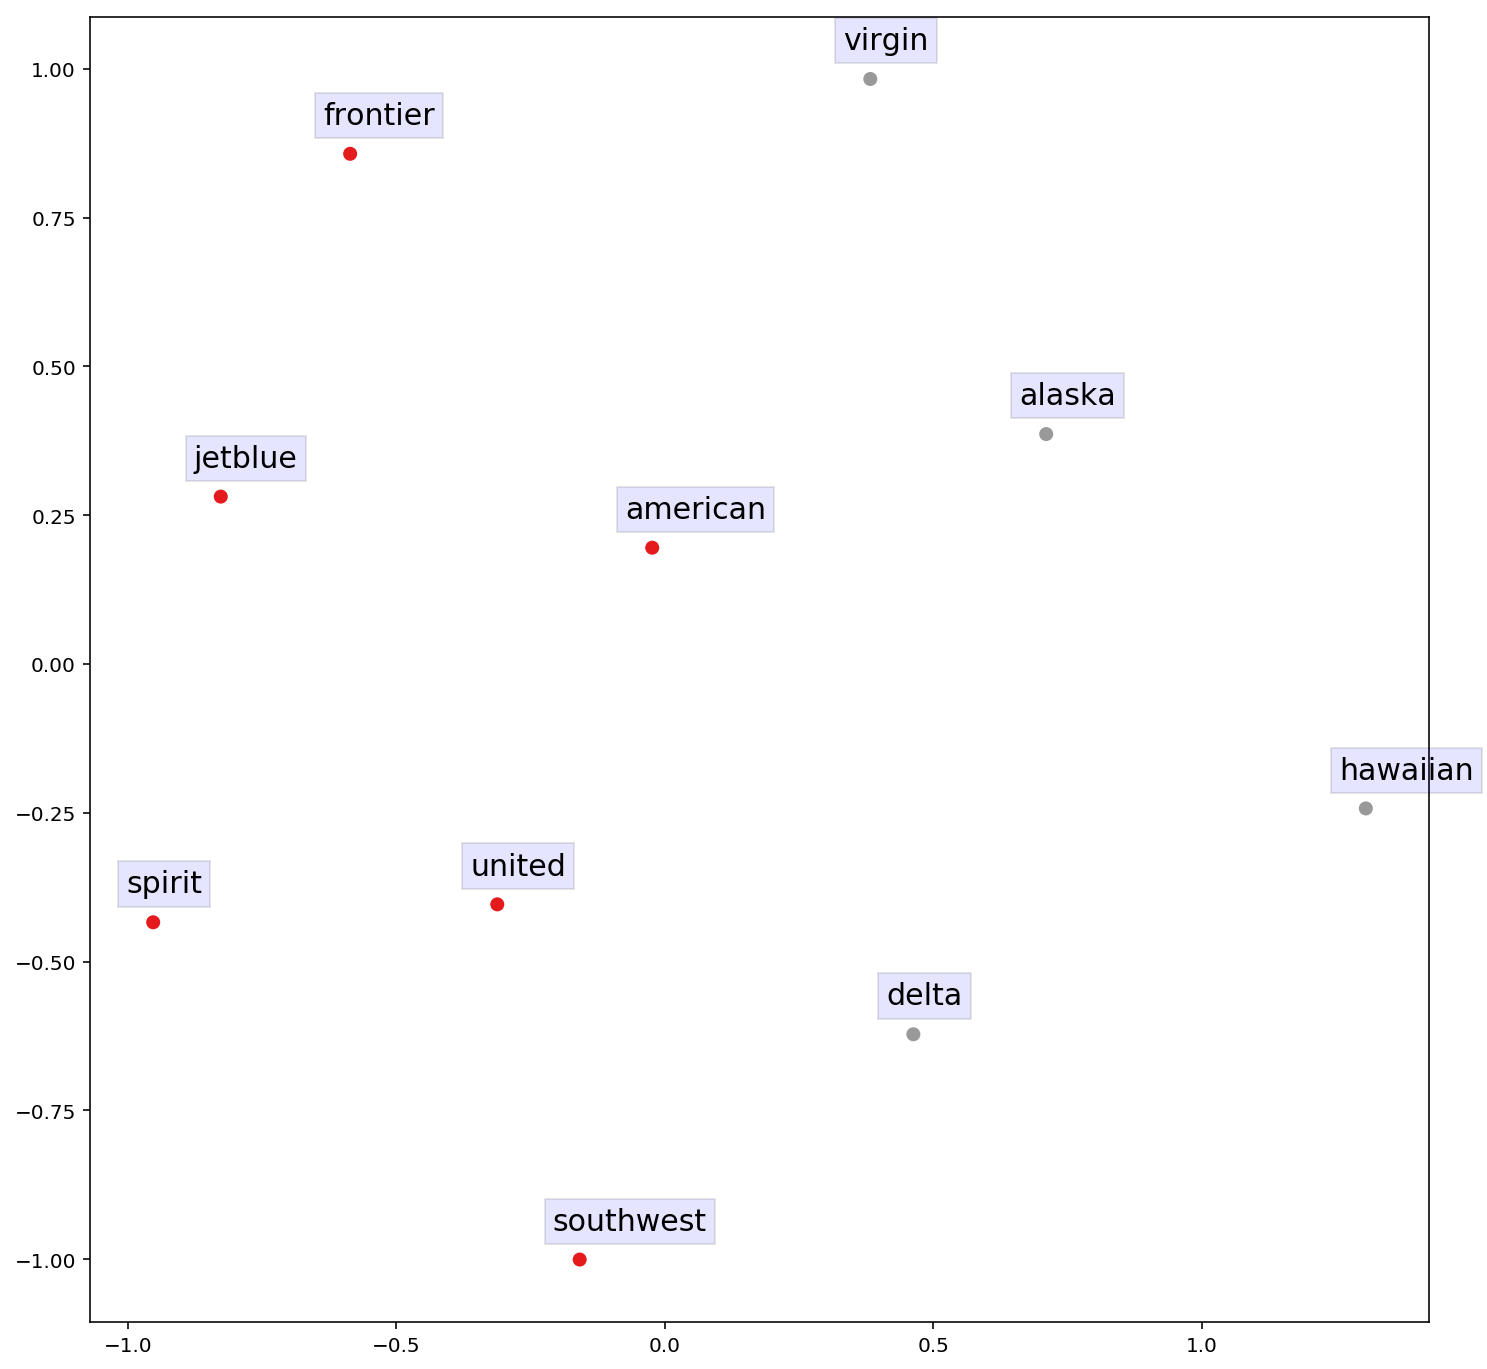

In [382]:
pos_x = [x[0] for x in pos]
pos_y = [x[1] for x in pos]
plt.figure(figsize=(12,12))
plt.scatter(pos_x, pos_y, c = clusters, cmap='Set1')
for i in range(len(airlines_short)):
    plt.text(pos_x[i]-0.05, pos_y[i]+0.05, airlines_short[i], fontsize = 15, bbox=dict(facecolor='blue', alpha=0.1))
    plt.colormaps()
plt.show()